<a href="https://colab.research.google.com/github/brian-ho/intro-to-urban-data/blob/main/Scale/S01_Grasshopper_and_wiring_it_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **01 Scale** Grasshopper and wiring it all up

```
    Class       ARCH 6131 Urban Design Methods / Skills / Tools 1
                Tata Innovation Center
                Fall 2025
                Monday 9:30 AM to 12 PM

    Instructor  Brian Ho
                brian@brian-ho.io
```

In Measure, you learned the basics of working with Python and Notebooks to create, collect, and use urban data at the scale of the site. In Scale, you will expand beyond the site to the city — and grow your craft with new methods of engaging with the data.

This notebook shows how you can put together the individual pieces you learned in Measure to: read in data from the site, organize it, and represent it on a basemap. It assumes you've worked through the previous notebooks in Measure! If you haven't, definitely run through them in advance.

Let's say we want to create a drawing the locates photographs taken around a city in a 3D context and annotates them with their color information. In this notebook we will:

- Load in images and external files
- Create data from the image
- Write that data to Rhino
- Use Grasshopper to add other details


In [ ]:
!pip install https://intro-to-urban-data.s3.amazonaws.com/rhino3dm-8.0.0b2-cp310-cp310-linux_x86_64.whl --quiet
!pip install pillow-heif geoplot --quiet

## Load in images and get data

As before, we'll connect to Google Drive and use existing Python packages to load in image files.


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

As before, we'll use a set of Python packages and libraries.


In [1]:
import rhino3dm
import PIL
import geopandas as gpd
import pandas as pd
import os
from pillow_heif import HeifImagePlugin
from pathlib import Path
from shapely.geometry import Point
from shapely.ops import orient
import geoplot

# This gives us a set of image file extensions
IMAGE_FILE_EXTENSIONS = {
    ex.lower()
    for ex, f in PIL.Image.registered_extensions().items()
    if f in PIL.Image.OPEN
}
IMAGE_FILE_EXTENSIONS.add(".HEIC".lower())

In [6]:
# Update this to match a path in Google Drive: "/content/drive/path/to/your/data"
DATA_DIRECTORY = "example_data"

We'll set up some helper functions to work with the data. If parts of these seem unfamiliar, refer to the cooresponding notebooks in Measure. For each image we'll want to get some basic pieces of information:

- Latitude and longitude: location
- Bearing: which way the camera is facing
- Colors: the most common colors and their respective frequency


In [3]:
GPS_LAT_REF = "GPSLatitudeRef"
GPS_LAT = "GPSLatitude"
GPS_LNG_REF = "GPSLongitudeRef"
GPS_LNG = "GPSLongitude"
GPS_IMG_DIRECTION = "GPSImgDirection"


def parse_degrees_to_decimals(degrees, reference):
    """Transforms angular degrees into decimal degrees."""

    sign = -1.0 if reference in ("S", "W") else 1.0
    decimals = degrees[0] + degrees[1] / 60 + (degrees[2] / (60 * 60))
    return decimals * sign


def get_gps_data(img):
    """Gets the direction, latitude, and longitude from an image."""

    img_exif = img.getexif()
    gps_data = {
        "direction": None,
        "latitude": None,
        "longitude": None,
    }

    try:
        all_gps = img_exif.get_ifd(PIL.ExifTags.IFD.GPSInfo)
        gps_info = {}

        for tag, value in all_gps.items():
            tag_name = PIL.ExifTags.GPSTAGS.get(tag, tag)
            gps_info[tag_name] = value

        gps_data["direction"] = gps_info[GPS_IMG_DIRECTION]
        gps_data["latitude"] = parse_degrees_to_decimals(
            gps_info[GPS_LAT], gps_info[GPS_LAT_REF]
        )
        gps_data["longitude"] = parse_degrees_to_decimals(
            gps_info[GPS_LNG], gps_info[GPS_LNG_REF]
        )

    except KeyError:
        pass

    return gps_data


def palette_color_to_rgb(palette, color):
    """Converts an index to an RGB color value from the palette."""
    return palette[color * 3 : color * 3 + 3]


def get_color_data(img):
    """Gets the 10 most common colors in an image."""
    converted_img = img.convert("P")
    palette = converted_img.getpalette()
    converted_img.thumbnail((100, 100))

    color_counts = converted_img.getcolors()
    color_counts.sort(key=lambda x: x[0], reverse=True)

    color_data = {
        "color_count": [],
        "red": [],
        "green": [],
        "blue": [],
    }

    for k, v in color_counts[:10]:
        r, g, b = palette_color_to_rgb(palette, v)
        color_data["color_count"].append(k)
        color_data["red"].append(r)
        color_data["green"].append(g)
        color_data["blue"].append(b)

    return color_data

After defining those helpers, we can call them in a single function. This returns a dictionary which we can convert to a table, which we can use later for both Rhino and Grasshopper.


In [7]:
def get_info_from_image(img_file):
    """Get all the information we want for an image."""
    img = PIL.Image.open(img_file)
    img_data = {
        "file_name": img_file.name,
        **get_gps_data(img),
        **get_color_data(img),
    }
    img.close()
    return img_data

In [8]:
images_data = []

for filepath in os.listdir(DATA_DIRECTORY):
    if any(filepath.lower().endswith(ext) for ext in IMAGE_FILE_EXTENSIONS):
        image_data = get_info_from_image(Path(DATA_DIRECTORY) / filepath)

        if image_data["latitude"] is None or image_data["longitude"] is None:
            continue

        images_data.append(image_data)

print(f"Got data from {len(images_data)} images")

Got data from 2 images


Let's take a look at what the data looks like for a single image. We should see:

- File name
- Directioin
- Location, as latitude and longitude
- 10 most common colors, as frequency and RGB values


In [9]:
images_data[0]

{'file_name': 'IMG_4106.HEIC',
 'direction': 54.84037396121884,
 'latitude': 40.73041944444444,
 'longitude': -74.00431111111111,
 'color_count': [3118, 798, 743, 610, 585, 373, 288, 241, 162, 124],
 'red': [0, 51, 51, 51, 0, 0, 51, 102, 0, 102],
 'green': [0, 0, 51, 51, 51, 0, 0, 51, 51, 102],
 'blue': [0, 0, 51, 0, 0, 51, 51, 51, 51, 51]}

## Load in map data

So we have some image data! Let's set up our basemap. We'll load in data from a GeoJSON file of NYC. You'll notice that almost all GeoJSON are set up in coordinates: latitude and longitude degrees. This makes a lot of sense if you need to make a map of a whole country, or the whole world!

But because we want to bring this data into Rhino, we'd prefer it were in meters or feet. Converting geospatial data like this requires _reprojecting_ the data. All geospatial data has an inherent projection — a way of translating between the real world (where the world is round) and a map representation (in 2D). And you can define projections to have varying degrees of accuracy in different regions and scales; these are described with a Coordinate Reference System, or CRS.

There's a lot more to the topic, but the key piece here is that we'll convert the map data to a [CRS specific to NYC and uses feet](https://epsg.io/2263). GeoPandas support that for GeoDataFrames using the `to_crs()` method.


In [10]:
# We'll use https://epsg.io/2263 here.
# to_crs() can take the ESPG number, but therer aer many different ways to specify a CRS.
buildings_gdf = gpd.read_file(Path(DATA_DIRECTORY) / "buildings.geojson").to_crs(2263)
nyc_gdf = gpd.read_file(geoplot.datasets.get_path("nyc_boroughs")).to_crs(2263)

Let's take a look at the data. You'll see that the units of the X and Y axis are very large, but have the right range. They're in feet!


<Axes: >

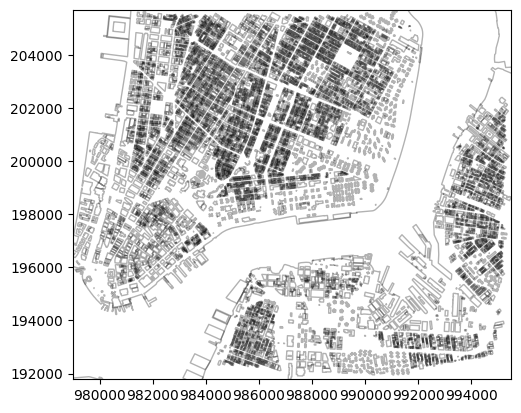

In [11]:
# We can use the total_bounds of the geometry to zoom in our view
bounds = buildings_gdf.geometry.total_bounds

plt = pd.concat([buildings_gdf, nyc_gdf]).plot(facecolor="none", alpha=0.3)
plt.set_xlim(bounds[0], bounds[2])
plt.set_ylim(bounds[1], bounds[3])
plt

<Axes: >

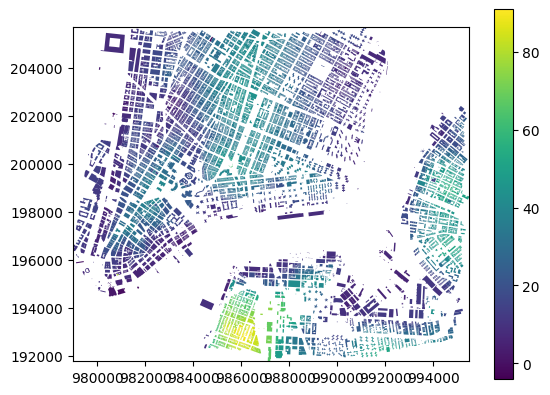

In [12]:
# You can also plot while coloring against a numeric column
plt = buildings_gdf.plot(column="groundelev", legend=True)
plt.set_xlim(bounds[0], bounds[2])
plt.set_ylim(bounds[1], bounds[3])
plt

OK, now that we have some NYC data, let's filter it to only the area around our images. We'll do this using a set of geospatial operations that may be familiar from GIS: a buffer and spatial join.

First, let's create a GeoDataFrame from our image data. Because we created a dictioinary before, we can construct the GeoDataFrame from it.


In [13]:
# We'll construct a point geometry from the longitude and latitude.
point_geoms = [Point(img["longitude"], img["latitude"]) for img in images_data]

# We'll load in the image data, plus the point geometry.
# Notice we also convert this data from ESPG 4326 (same as WGS 84: latitude and longitude degrees) to ESPG 2236.
all_images_gdf = gpd.GeoDataFrame(images_data, geometry=point_geoms, crs=4326).to_crs(
    2263
)

<Axes: >

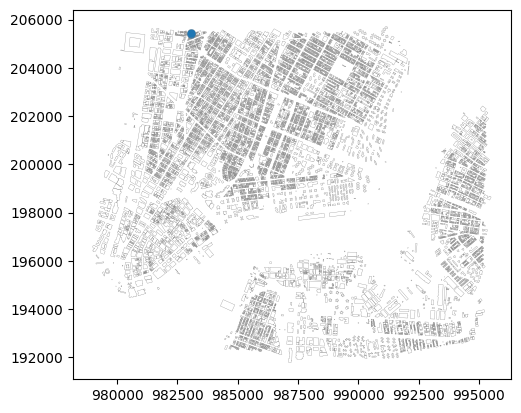

In [14]:
# Let's see what it looks like!
pd.concat([all_images_gdf, buildings_gdf]).plot(
    facecolor="none", edgecolor="grey", lw=0.2
)

Now that we have the images, we'll apply the buffer and spatial join.

- A `buffer()` expands (or shrinks) a geometry a set distance
- A spatial join or `sjoin()` matches geometry that intersect, contain, or fall within another

In our case, we want to union all the points, buffer them into a single region by a quarter-mile, and get all the buildings in that vicinity. You may want to read more about spatial joins [here](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html#geopandas.GeoDataFrame.sjoin).


<Axes: >

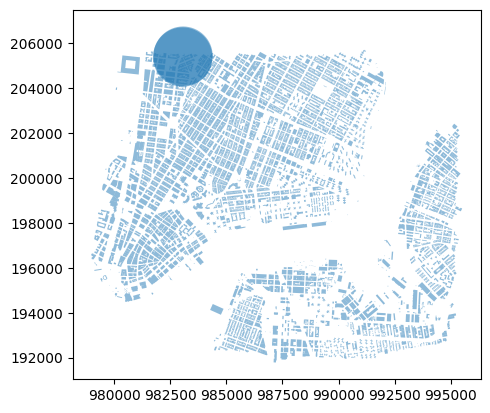

In [15]:
# Define our intended distance
distance = 5280 / 4

# Create a copy of our image GeoDataFrame
all_images_buffer_gdf = all_images_gdf.copy()

# Buffer the geometry in the copy of the image GeoDataFrame
all_images_buffer_gdf.geometry = all_images_buffer_gdf.buffer(distance)

# Let's see our buffer regions
pd.concat([all_images_buffer_gdf, buildings_gdf]).plot(alpha=0.5)

There are 939 buildings within 1320.0 feet of all the images.


<Axes: >

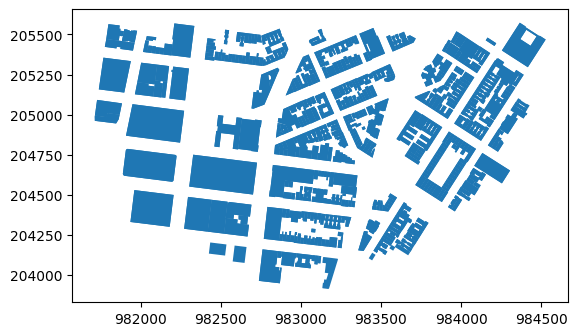

In [16]:
# Spatial join the buildings to the buffered region
# The how='left' argument means we keep the data from the "left" GeoDataFrame or the buildings after joining on geometry
buildings_around_images_gdf = buildings_gdf.sjoin(all_images_buffer_gdf)

# Let's check the results
print(
    f"There are {len(buildings_around_images_gdf)} buildings within {distance} feet of all the images."
)
buildings_around_images_gdf.plot()

OK, we have building! We want to put these into a Rhino file. Of course, we could add these to Rhino as 2D curves and surfaces. But where's the fun in that? Ideally, these are 3D extrusions with the appropriate height in feet.

To do that, we need some data about the height of the buildings. Is there something we could use?


In [17]:
# GeoDataFrames (and DataFrames) let you check all the columns quite easily
for col in buildings_around_images_gdf.columns:
    print(col)

base_bbl
cnstrct_yr
doitt_id
groundelev
heightroof
mpluto_bbl
name
geometry
index_right
file_name
direction
latitude
longitude
color_count
red
green
blue


The `groundelev` and `heightroof` seem promising!


<Axes: >

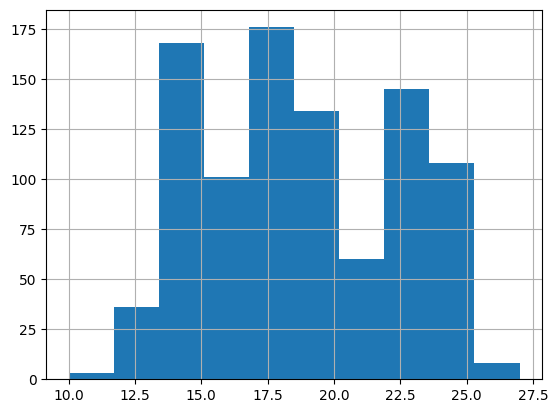

In [18]:
# We can see the distribution of values in any column as a histogram.
# Notice the ground elevation is not always 0.
buildings_around_images_gdf["groundelev"].hist()

<Axes: >

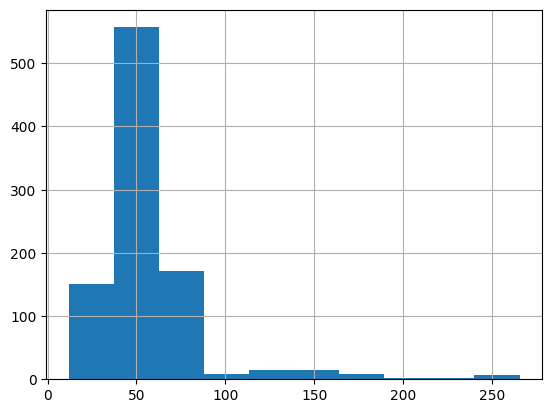

In [19]:
# Most buiildings are under 100' in height.
buildings_around_images_gdf["heightroof"].hist()

So it seem like if we want to extrude all out buildings from 0 to some height, we'll need to make a new column that measure the difference between the `heightroof` and `groundelev` values. Easy enough!


In [20]:
# You can subtract columns with scalar (numeric) values directly.
buildings_around_images_gdf["extrusion_height"] = (
    buildings_around_images_gdf["heightroof"]
    - buildings_around_images_gdf["groundelev"]
)

## Write data to Rhino

Now that we have images and buildings, we can put them in Rhino.


In [21]:
# Make an empty file and default layer
new_3dm = rhino3dm.File3dm()
new_3dm.Layers.AddLayer("BASE", (255, 255, 255, 255))

0

In [22]:
def create_extrusion(geometry, height):
    """Helper function that creates a Rhino extrusion based on a geometry and a height."""
    polyline_curve = rhino3dm.Polyline(
        [rhino3dm.Point3d(x, y, 0) for (x, y) in orient(geometry).exterior.coords]
    ).ToPolylineCurve()

    return rhino3dm.Extrusion.Create(polyline_curve, height=height, cap=True)


# Add an extrusion for each building
for i, building in buildings_around_images_gdf.iterrows():
    extrusion = create_extrusion(building["geometry"], building["heightroof"])
    new_3dm.Objects.Add(extrusion)

In [23]:
# Add a curve for the outline of the boroughs
for i, borough in nyc_gdf.explode(index_parts=False).iterrows():
    polyline_curve = rhino3dm.Polyline(
        [
            rhino3dm.Point3d(x, y, 0)
            for (x, y) in orient(borough["geometry"]).exterior.coords
        ]
    ).ToPolylineCurve()
    new_3dm.Objects.Add(polyline_curve)

In [24]:
# Add each image as a point on its own layer
for _, img in all_images_gdf.iterrows():
    # We'll use the most common color for the layer
    r = int(img["red"][0] * 255)
    g = int(img["green"][0] * 255)
    b = int(img["blue"][0] * 255)
    layer_index = new_3dm.Layers.AddLayer(img["file_name"], (r, g, b, 255))

    # Create the object attributes so things land on the right layerr
    attributes = rhino3dm.ObjectAttributes()
    attributes.LayerIndex = layer_index

    # Construct and add a ponit
    point = rhino3dm.Point(rhino3dm.Point3d(img["geometry"].x, img["geometry"].y, 0))
    new_3dm.Objects.Add(point, attributes)

In [25]:
# Save the file. Make sure to check the version matches your version of Rhino.
new_3dm.Write("example.3dm", version=7)

True

## Use Grasshopper to add in other details

Your Rhino file now contains the basic building geometry. What about the color information? We can use Grasshopper, which gives us greater control and flexibility to design with data in Rhino.

We'll use CSV files as a way to bring information from this notebook to Rhino.


In [26]:
# Save the image location information as one file
all_images_gdf["longitude"] = all_images_gdf.geometry.x
all_images_gdf["latitude"] = all_images_gdf.geometry.y

all_images_gdf.to_csv("example.csv", index=False, sep=";")

We'll switch to Grasshopper for the rest. Follow along in `S02_Welcome_to_Grasshopper.ghx`! Don't forget to download your CSV file from your Google Drive.
